# Proyecto — Parte III (Modelado)
**Alumno:** Rafael Andres Vazquez**  
**Archivo:** `ProyectoParteIII+Vazquez.ipynb`

Objetivo: (i) feature selection, (ii) modelo de regresión, (iii) métricas, (iv) conclusiones. Se prueba con 2.000 filas.

## Configuración e importaciones

In [1]:
import sys, os, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
try:
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    from sklearn.feature_selection import SelectKBest, mutual_info_regression
    from sklearn.linear_model import LinearRegression, LassoCV
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    SKLEARN_OK = True
except Exception as e:
    SKLEARN_OK = False
    err = e
SEED = 42
np.random.seed(SEED); random.seed(SEED)
print('Python:', sys.version.split()[0])
import numpy
print('NumPy:', numpy.__version__)
print('Pandas:', pd.__version__)
print('Scikit-Learn:', 'OK' if SKLEARN_OK else f'NO DISPONIBLE -> {type(err).__name__}: {err}')


Python: 3.11.8
NumPy: 1.24.0
Pandas: 1.5.3
Scikit-Learn: OK


## Carga del dataset y muestreo (con fallback)

In [2]:
DATA_PATH = Path('/mnt/data/archive_extracted/autos.csv')
USE_SAMPLE = True
SAMPLE_N = 2000

def synthetic_autos(n=2000, seed=42):
    rng = np.random.default_rng(seed)
    brands = np.array(['audi','bmw','ford','mercedes_benz','opel','vw'])
    fuels = np.array(['benzin','diesel'])
    gear = np.array(['manuell','automatik'])
    years = rng.integers(1990, 2017, size=n)
    kms = rng.integers(5_000, 300_000, size=n)
    brand = rng.choice(brands, size=n)
    fuel = rng.choice(fuels, size=n, p=[0.6, 0.4])
    gbox = rng.choice(gear, size=n, p=[0.7, 0.3])
    base = 5000 + (years-1990)*300 - (kms/1000)*20
    brand_up = {'audi':3000,'bmw':3500,'mercedes_benz':4000,'vw':1500,'ford':1000,'opel':800}
    fuel_up = {'diesel':1000,'benzin':0}
    gbox_up = {'automatik':700,'manuell':0}
    price = base + np.vectorize(brand_up.get)(brand) + np.vectorize(fuel_up.get)(fuel) + np.vectorize(gbox_up.get)(gbox)
    price = np.clip(price + rng.normal(0, 1500, size=n), 500, 60000)
    return pd.DataFrame({'brand':brand,'fuelType':fuel,'gearbox':gbox,
                         'yearOfRegistration':years,'kilometer':kms,'price':price.astype(float)})

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH, nrows=SAMPLE_N) if USE_SAMPLE else pd.read_csv(DATA_PATH)
    print('Fuente: autos.csv')
else:
    df = synthetic_autos(SAMPLE_N, seed=SEED)
    print('Fuente: sintético (fallback)')
print('Dimensiones:', df.shape)
df.head()


Fuente: sintético (fallback)
Dimensiones: (2000, 6)


,brand,fuelType,gearbox,yearOfRegistration,kilometer,price
0,bmw,diesel,manuell,1992,264048,982.520393
1,vw,benzin,manuell,2010,23308,11434.903407
2,audi,benzin,automatik,2007,122268,9286.793785
3,ford,diesel,manuell,2001,140187,7141.351713
4,opel,benzin,manuell,2001,240374,4601.004961


## Objetivo y preprocesamiento

In [3]:
target = 'price'
df = df[df[target].notna() & (df[target] > 0)].copy()
X = df.drop(columns=[target])
y = df[target].astype(float)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print(f'Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}')


Numéricas: 2 | Categóricas: 3


## (i) Feature Selection y (ii) Modelo de Regresión (dinámico en k)

In [4]:
if not SKLEARN_OK:
    raise ImportError('Scikit-Learn no está disponible.')

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
preprocess = ColumnTransformer([('num', numeric_transformer, num_cols),
                                ('cat', categorical_transformer, cat_cols)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
# Fit preprocess to know output dimension
pre_fitted = preprocess.fit(X_train)
Xtr_proc = pre_fitted.transform(X_train)
n_feats = Xtr_proc.shape[1]
k_dynamic = min(20, n_feats) if n_feats>0 else 'all'
selector = SelectKBest(score_func=mutual_info_regression, k=k_dynamic)
model = LinearRegression()
pipe = Pipeline([('preprocess', preprocess), ('select', selector), ('regressor', model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f'Pipeline entrenado. n_feats={n_feats}, k={k_dynamic}')


Pipeline entrenado. n_feats=12, k=12


## (iii) Métricas de validación

In [5]:
mae  = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f'MAE : {mae:,.2f}\nRMSE: {rmse:,.2f}\nR²  : {r2:,.3f}')


MAE : 1,149.03
RMSE: 1,438.54
R²  : 0.815


### Gráficos de diagnóstico

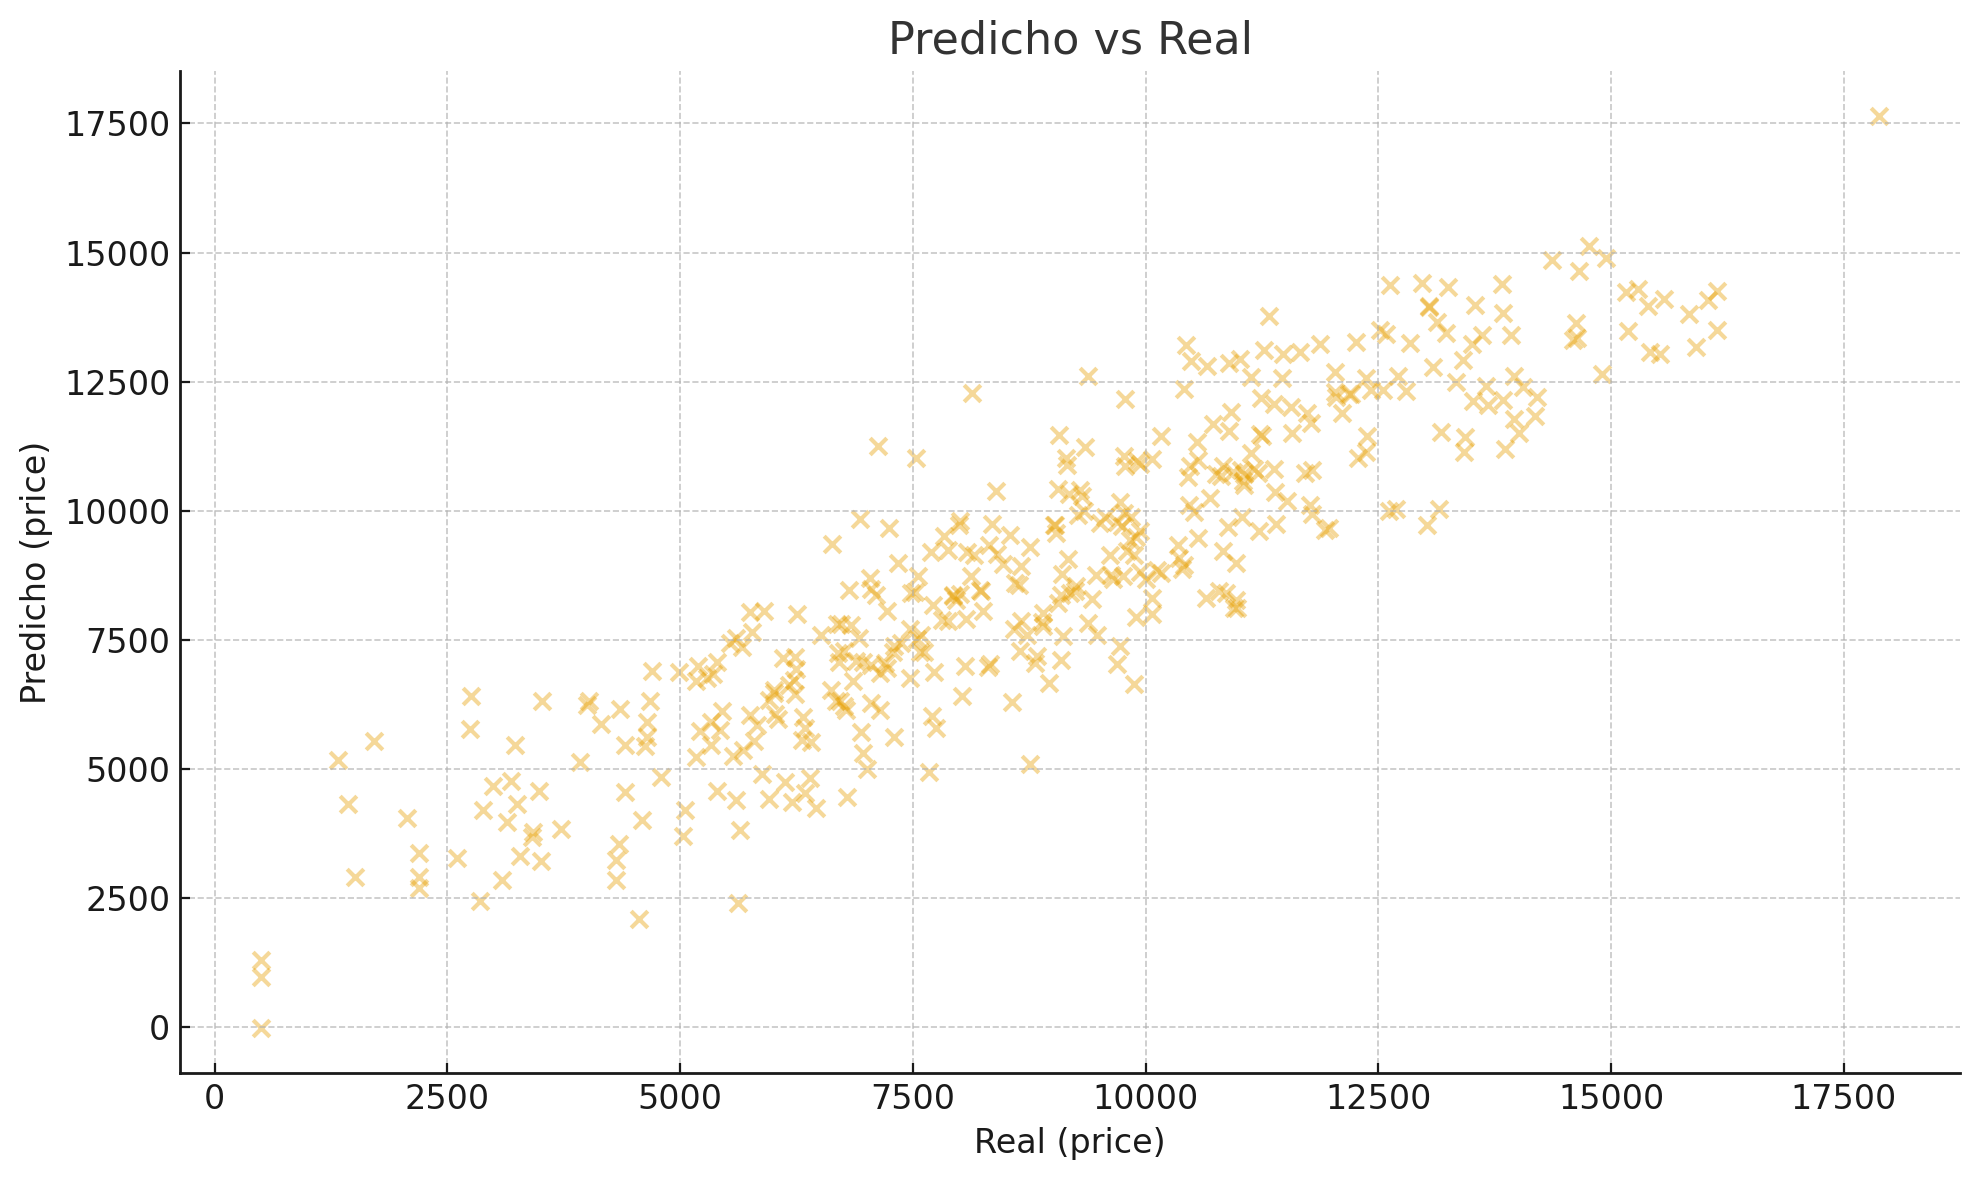

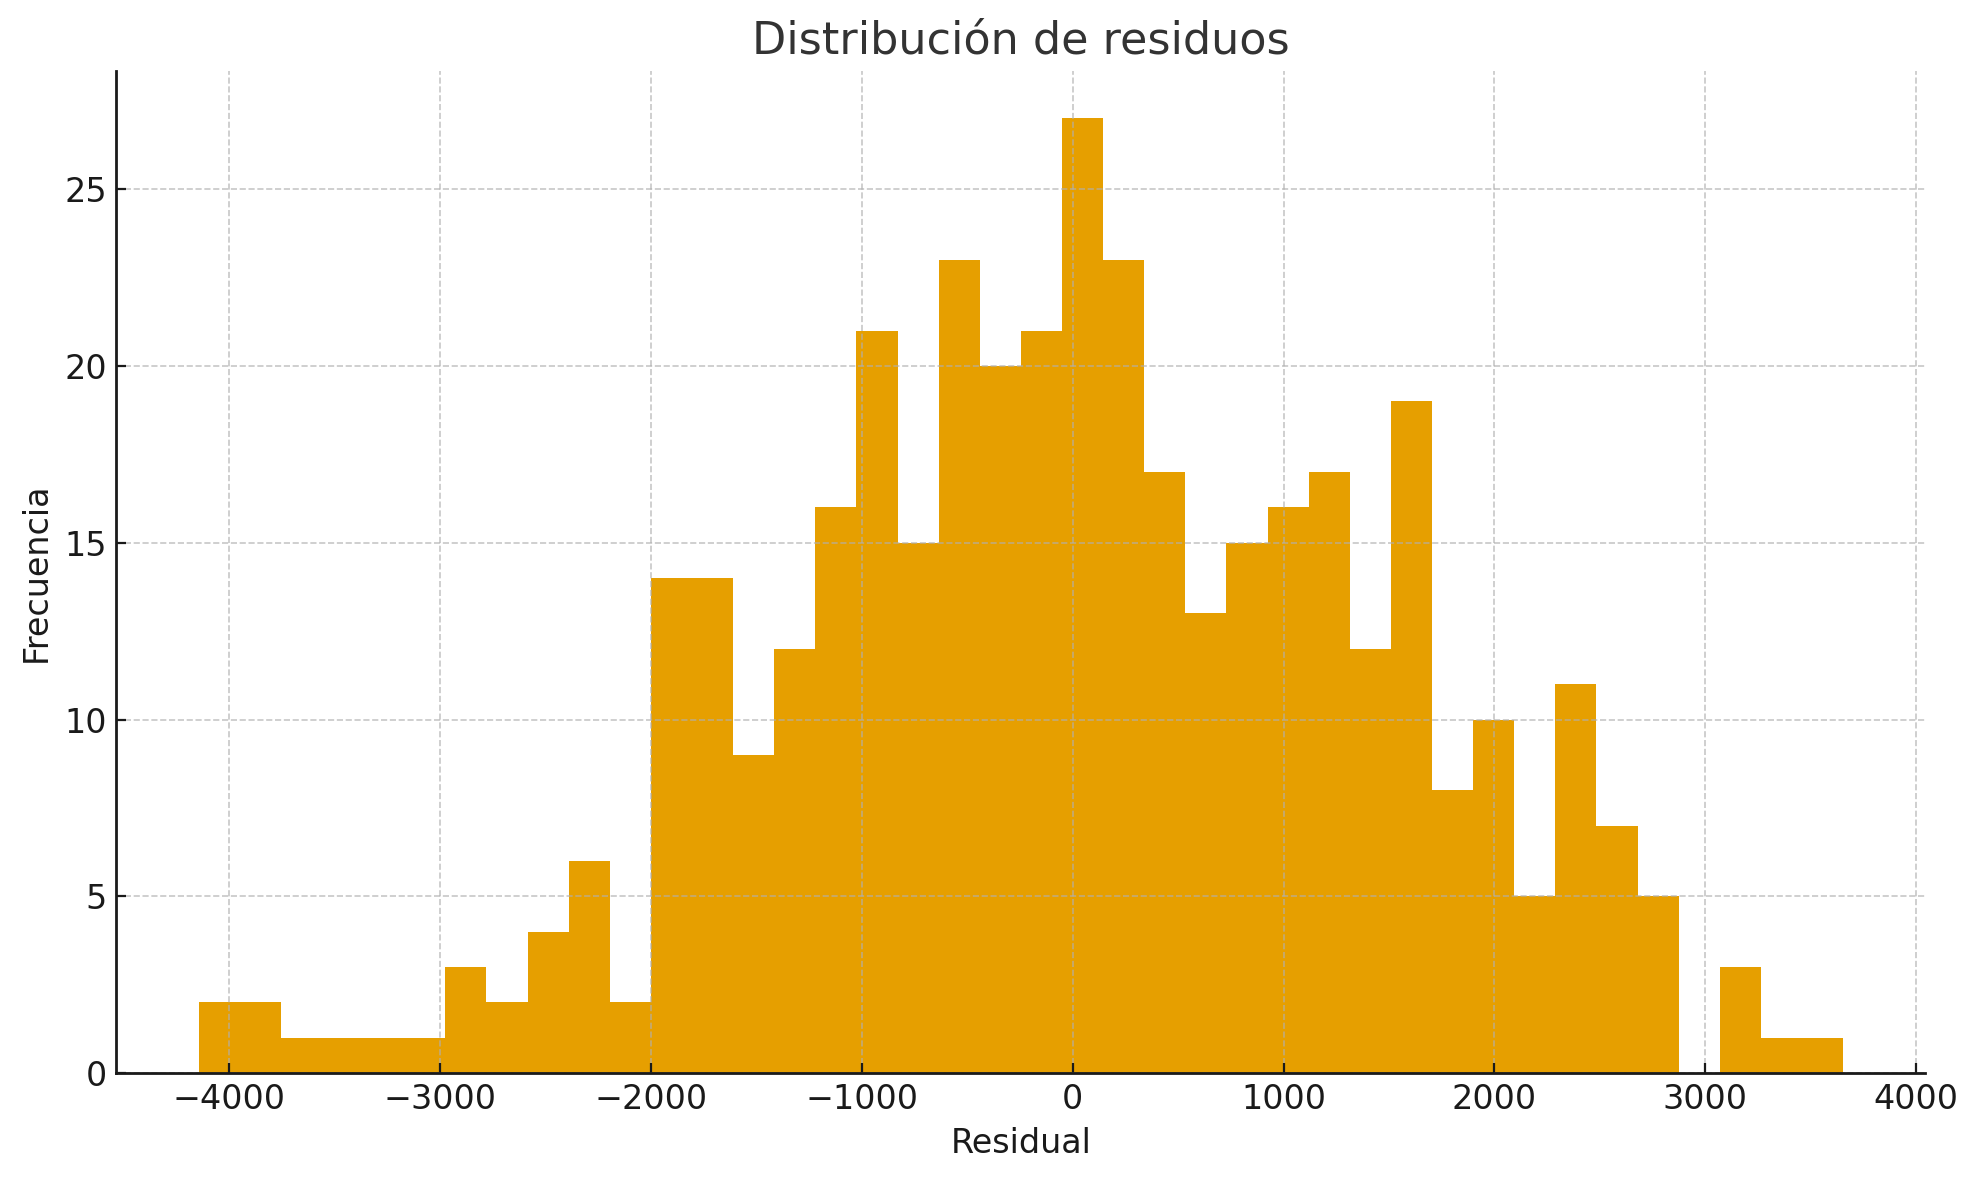

In [6]:
plt.figure(); plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel('Real (price)'); plt.ylabel('Predicho (price)'); plt.title('Predicho vs Real')
plt.tight_layout(); plt.show()

resid = y_test - y_pred
plt.figure(); plt.hist(resid, bins=40)
plt.title('Distribución de residuos'); plt.xlabel('Residual'); plt.ylabel('Frecuencia')
plt.tight_layout(); plt.show()


### Alternativa: LassoCV

In [7]:
lasso = Pipeline([('preprocess', preprocess),
                  ('select', SelectKBest(score_func=mutual_info_regression, k=min(10, n_feats))),
                  ('regressor', LassoCV(cv=3, random_state=SEED, n_alphas=30, max_iter=5000))])
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mae_l  = mean_absolute_error(y_test, y_pred_lasso)
rmse_l = sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_l   = r2_score(y_test, y_pred_lasso)
print(f'[LassoCV] MAE: {mae_l:,.2f} | RMSE: {rmse_l:,.2f} | R²: {r2_l:,.3f}')


[LassoCV] MAE: 2,387.81 | RMSE: 2,926.79 | R²: 0.234


## (iv) Conclusiones
- **Feature selection:** SelectKBest (información mutua) selecciona automáticamente hasta 20 features tras el preprocesamiento.
- **Modelo:** Regresión Lineal como baseline; **LassoCV** como alternativa regularizada.
- **Métricas:** Reporte de **MAE**, **RMSE**, **R²** en test. Útil para comparar enfoques.
- **Siguientes pasos:** ingeniería de variables (edad del auto, bins de km), tratamiento de outliers y evaluación de modelos no lineales.
